# Figure 3 - Panels A-F

In [ ]:
%load_ext autoreload
%autoreload 2

import os
print(os.getcwd())
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))
print(os.getcwd())

In [4]:
import torch
import numpy as np
import h5py
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os, sys

from matplotlib.colors import LogNorm
from scipy.stats import pearsonr, spearmanr
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans

from matplotlib.ticker import LogFormatterExponent

sys.path.append(os.getcwd() + '/PGM/source/')
sys.path.append(os.getcwd() + '/PGM/utilities/')
sys.path.append(os.getcwd() + '/RTRBM/')

from utils.funcs import *
import RBM_utils
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_ import RTRBM

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

C:\Users\luukh\OneDrive\Intern/PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
C:\Users\luukh\OneDrive\Intern/PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
C:\Users\luukh\OneDrive\Intern/PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\luukh\OneDrive\Intern/PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


### load files

In [9]:
def load_dataset(path2dataset):
    f = h5py.File(path2dataset, 'r')
    labels = f['Data']['Brain']['Labels'][:].T.astype('bool')
    Coordinates = f['Data']['Brain']['Coordinates'][:].T # Spatial coordinates
    Labels = f['Data']['Brain']['Labels'][:].T.astype('bool')
    Spikes = f['Data']['Brain']['Analysis']['ThresholdedSpikes'][:].astype('bool')
    f.close()

    mask = Labels.max(-1) # Discard neurons not mapped to Zbrain atlas.
    Spikes = Spikes[:,mask]
    Coordinates = Coordinates[mask]

    return Spikes,Coordinates

In [10]:
data_dir = '../data/figure3_zebrafish'  # Directory path to save the model files to
models_dir = '../models/figure3_zebrafish'

list_datasets = [
    'fish1_20180706_Run04',
    'fish2_20180911_Run01',
    'fish3_20180912_Run01',
    'fish4_20180913_Run01',
    'fish5_20190109_Run04',
    'fish6_20181206_Run03',
    'fish7_20190102_Run01',
    'fish8_20181206_Run05',
]

In [11]:
dataset_idx = 3# The dataset used.
dataset = list_datasets[dataset_idx]

spikes, coordinates = load_dataset(data_dir + '/fish%s/rbm_%s.h5'%(dataset_idx+1, dataset))
spikes = torch.tensor(spikes.T)

path2rtrbm = models_dir + '/fish%s/rtrbm_%s_transfer'%(dataset_idx+1, dataset)
path2crbm = models_dir + '/fish%s/rbm_%s.data'%(dataset_idx+1, dataset)
path2crbm_transfer = models_dir + '/fish%s/rbm_%s_transfer.data'%(dataset_idx+1, dataset)

try:
    try:
        rbm = RBM_utils.loadRBM(path2crbm_transfer)
    except:
        rbm = RBM_utils.loadRBM(path2crbm)
except:
    print('cRBM file not found, download or retrain cRBM with the notebook Train cRBM & RTRBM on zebrafish.ipynb')
try:
    rtrbm = torch.load(path2rtrbm)
    W = rtrbm.W.cpu()
    U = rtrbm.U.cpu()
except:
    print('RTRBM file not found, download or retrain cRBM with the notebook Train cRBM & RTRBM on zebrafish.ipynb')
n_h, n_v = rtrbm.W.shape

## Whole brain image

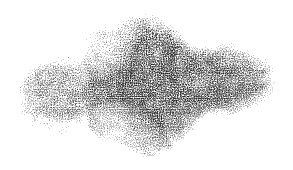

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes.set_aspect('equal')
axes.scatter(coordinates[:, 1], coordinates[:, 0], s=1, color='k', alpha=0.2, marker='.', linewidths=0.45)
axes.axis('off')

plt.show()

### Weight and connectivity distributions

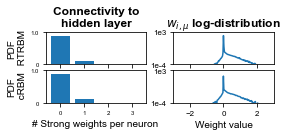

In [13]:
n = 5000
# th = np.sort(abs(rtrbm.W.cpu().numpy().flatten()))[-n]
th = np.sort(np.max(abs(rtrbm.W.cpu().numpy()), axis=0))[-n]

n_connections = np.sum(1.0 * (np.abs(rtrbm.W.cpu().numpy())>th), 0)
n_connections = n_connections[n_connections<7]

plt.rcParams["font.family"] = "Arial"
fig, axes = plt.subplots(2, 2, figsize=(4, 2), sharex='col')
n_con, freq = np.unique(n_connections, return_counts=True)
axes[0, 0].bar(n_con, freq/sum(freq))
axes[0, 0].set_title('Connectivity to\nhidden layer', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='both', which='major', labelsize=6)
axes[0, 0].set_xticks(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[0, 0].set_xticklabels(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_yticklabels(['0', '1.0'])
# axes[0, 0].set_yscale('log')
axes[0, 0].set_ylabel('PDF\n RTRBM', fontsize=10)

g = sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10], ax=axes[0, 1])
g.set(ylabel=None)
axes[0, 1].set_xlim([-3, 3])
axes[0, 1].set_ylim([1e-4, 1e3])
axes[0, 1].set_yticks([1e-4, 1e3])
axes[0, 1].set_yticklabels(['1e-4', '1e3'])
axes[0, 1].set_title(r'$w_{i, \mu}$ log-distribution', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='both', which='major', labelsize=8)
# axes[0, 0].set_box_aspect(1)

th = np.sort(np.max(abs(rbm.weights), axis=0))[-n]
n_connections = np.sum(1.0 * (np.abs(rbm.weights)>th), 0)
n_connections = n_connections[n_connections<7]

n_con, freq = np.unique(n_connections, return_counts=True)
axes[1, 0].bar(n_con, freq/sum(freq))
axes[1, 0].set_xlabel('# Strong weights per neuron ', fontsize=10)
axes[1, 0].tick_params(axis='both', which='major', labelsize=6)
axes[1, 0].set_xticks(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[1, 0].set_xticklabels(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['0', '1.0'])
# axes[1, 0].set_yscale('log')
axes[1, 0].set_ylabel('PDF\n cRBM', fontsize=10)

g = sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=axes[1, 1])
g.set(ylabel=None)
axes[1, 1].set_xlim([-3, 3])
axes[1, 1].set_ylim([1e-4, 1e3])
axes[1, 1].set_yticks([1e-4, 1e3])
axes[1, 1].set_yticklabels(['1e-4', '1e3'])
axes[1, 1].set_xlabel('Weight value', fontsize=10)
axes[1, 1].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout(h_pad=0, w_pad=0.4)
plt.show()

### Agglomerative clustering on U matrix

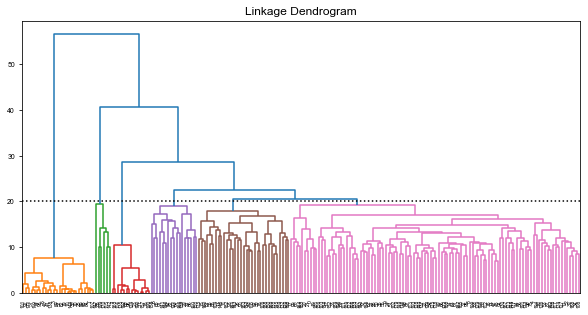

Number of unique clusters: 6


In [14]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Calculate the distance matrix
distance_matrix = sch.distance.pdist(rtrbm.U.cpu())

# Linkage matrix
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# Choose a cutoff threshold
cutoff_height = 20

# Plot the dendrogram
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
sch.dendrogram(linkage_matrix, color_threshold=cutoff_height, ax=ax)
ax.axhline(cutoff_height, c='k', linestyle=':')
ax.set_title('Linkage Dendrogram')
plt.show()

# Agglomerative clustering with a given cutoff threshold
clustering = AgglomerativeClustering(n_clusters=None, linkage='ward',
                                     distance_threshold=cutoff_height)
clustering.fit(rtrbm.U.cpu())

n_clusters = len(np.unique(clustering.labels_))
print(f'Number of unique clusters: {n_clusters}')

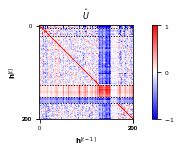

In [15]:
idx_U_sorted = np.argsort(clustering.fit_predict(rtrbm.U.cpu()))
U_ = rtrbm.U[idx_U_sorted, :][:, idx_U_sorted].cpu().detach()
W_ = rtrbm.W[idx_U_sorted, :].cpu().detach()

fig, axes = plt.subplots(1, 1, figsize=(3, 2))
cm = axes.imshow(U_, plt.get_cmap('bwr'), aspect='equal', vmin=-1, vmax=1)
cb = fig.colorbar(cm, ax=axes, shrink=1, ticks=[-1, 0, 1], pad=.1)
cb.minorticks_off()
cb.ax.set_yticklabels(['$-1$', '$0$', '$1$'], fontsize=6)
axes.set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=7)
axes.set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=7)
axes.set_title(r'$\hat{U}$', fontsize=8)
axes.set_xticks([0, 200, 200])
axes.set_xticklabels([0, 200, 200], fontsize=6)
axes.set_yticks([0, 200, 200])
axes.set_yticklabels([0, 200, 200], fontsize=6)

u, c = np.unique(clustering.labels_, return_counts=True)
c_cumsum = np.cumsum(c)
for c_i in range(n_clusters):
    axes.axhline(c_cumsum[c_i], linestyle=':', c='k', lw=1)
plt.tight_layout(pad=.25, w_pad=0)
plt.show()

Receptive field of hidden units (neural assemblies) color coded

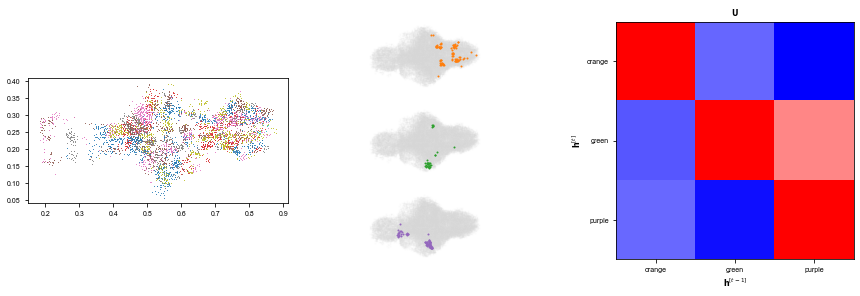

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(12, 4))
gs = fig.add_gridspec(3, 3)

it_color = 0
color_list = ['tab:blue', 'tab:red', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_sub = ['tab:orange', 'tab:green', 'tab:purple']
strongest_connections = np.argmax(np.abs(W_), 0)

ax = fig.add_subplot(gs[:, 0])
ax.set_aspect('equal')

for i in range(rtrbm.n_hidden): # 200 hiddens units
    color=color_list[it_color]    
    it_color+=1
    if i % 6 == 0 and i != 0:
        it_color = 0
    try: # not all hidden units find meaningful receptive fields
        RF_hi = coordinates[torch.where((torch.abs(W_[i, :])>th))[0], :]
        ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=1, linewidths=0.5, color=color)
    except:
        continue

it_color = 0
for i, h in enumerate([78, 37, 103]): # 200 hiddens units
    ax = fig.add_subplot(gs[i, 1])
    ax.set_aspect('equal')
    color=color_sub[it_color]
    it_color+=1
    if i % 3 == 0 and i != 0:
        it_color = 0
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    ax.scatter(coordinates[:, 1], coordinates[:, 0], marker='.', s=4, linewidths=1, color='lightgray', alpha=.05)
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=4, linewidths=1, color=color)
    ax.axis('off')

ax = fig.add_subplot(gs[:, 2])
ax.set_aspect('equal')
U_subset = np.array(rtrbm.U[[78, 37, 103],:].cpu())
U_subset = U_subset[:, [78, 37, 103]]
cm = ax.imshow(U_subset, plt.get_cmap('bwr'), aspect='equal', vmin=-1, vmax=1)
cb = fig.colorbar(cm, ax=axes, shrink=.5, ticks=[-1, 1])
cb.ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([label[4:] for label in color_sub])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([label[4:] for label in color_sub])
ax.set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=8)
ax.set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=8)
ax.set_title(r'$\mathbf{U}$', fontsize=8)

plt.show()

C:\Users\luukh\anaconda3\envs\multifish_squared\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: All-NaN slice encountered
C:\Users\luukh\anaconda3\envs\multifish_squared\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


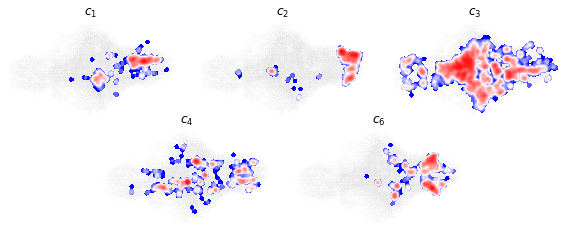

In [17]:
from matplotlib.collections import QuadMesh
import math
from scipy.spatial import KDTree

n = 5000
# th = np.sort(abs(rtrbm.W.cpu().numpy().flatten()))[-n]
th = np.sort(np.max(abs(rtrbm.W.cpu().numpy()), axis=0))[-n]

rad = .015 #um
dens_samp = .0025 #um
 
group_idx = clustering.labels_
sorted_group_idx = np.sort(group_idx)
sorted_idx = np.argsort(group_idx)
fig = plt.figure(figsize=(8, 3))
gs = gridspec.GridSpec(2, 6)

dim_ranges = [[np.min(c), np.max(c)] for c in coordinates.T]
dim_bins = [np.linspace(r[0], r[1], math.floor((r[1]-r[0])/dens_samp)) for r in dim_ranges]

for c_i in range(n_clusters):
    
#     th = np.sort(np.max(abs(rtrbm.W.cpu().numpy()[np.where(group_idx == c_i)[0], :]), axis=0))[-n]
    idx_pseg = np.where((torch.sum(torch.abs(rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]) > th, 0) >= 1) == 1)[0]
    # Create density map using KDTree for efficient calculation
    kdtree = KDTree(coordinates[idx_pseg])
    X = np.stack(np.meshgrid(*dim_bins, indexing='ij'))
    X = X.reshape(3, np.prod([len(b) for b in dim_bins]))
    density_map = np.array([len(p) for p in kdtree.query_ball_point(X.T, r=rad, p=2)], dtype=float)
    density_map = density_map.reshape([len(b) for b in dim_bins])
    density_map[density_map==0] = np.nan
    density_map_proj = np.nanmax(density_map, axis=2)
    
    if not np.isnan(np.nanmax(density_map_proj)):
    
        if c_i <= 2:
            ax = plt.subplot(gs[0, c_i*2:c_i*2+2])
#         elif c_i > 2:
#             ax = plt.subplot(gs[1, (c_i-3)*2+1:(c_i-3)*2+3])
        elif c_i == 3:
            ax = plt.subplot(gs[1, 1:3])
        elif c_i == 5:
            ax = plt.subplot(gs[1, 3:5])
        ax.set_aspect('equal')
        ax.scatter(coordinates[:, 1], coordinates[:, 0],
                   s=1, color='lightgray', alpha=0.05, marker='.')
        ax.imshow(np.flip(density_map_proj, axis=0), cmap='bwr', norm=mcolors.LogNorm(vmin=1, vmax=None),
                   extent=[dim_bins[1][0], dim_bins[1][-1], dim_bins[0][0], dim_bins[0][-1]],
                   zorder=2)
        ax.axis('off')
        ax.set_title(f'$c_{c_i+1}$', fontsize=12)
    
plt.tight_layout(pad=0, w_pad=0)
plt.show()

### Moments plot


According to the cRBM paper methodology, the data is arranged chronologically into 10 batches. Batch 2, 6, and 7 are designated as the test set, while the remaining batches are assigned to the train set. Therefore, the dataset is split into train and test sets following this protocol.

In [7]:
def train_test_split(data):
    batch_size = data.shape[1] // 10
    train = torch.zeros(data.shape[0], batch_size, 7)
    test = torch.zeros(data.shape[0], batch_size, 3)
    batch_index_shuffled = [0, 2, 3, 4, 7, 8, 9, 1, 5, 6]
    i = 0

    for batch in range(10):
        j = batch_index_shuffled[batch]
        if batch < 7:
            train[:, :, batch] = data[:, j * batch_size:(j + 1) * batch_size]
        if batch >= 7:
            test[:, :, batch-7] = data[:, j * batch_size:(j + 1) * batch_size]

    return train, test


C:\Users\luukh\AppData\Local\Temp\ipykernel_9940\1716790530.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, test = train_test_split(torch.tensor(spikes))


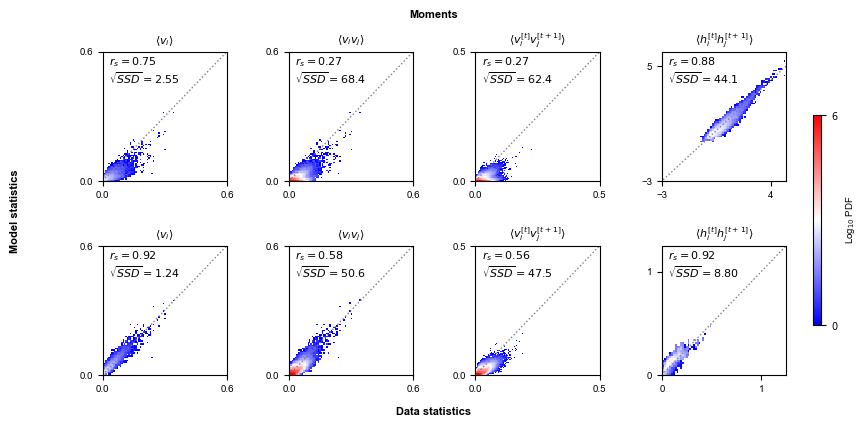

In [8]:
inferred_dir = 'C:/Users/luukh/OneDrive/Intern/RTRBM/inferred/figure3_zebrafish/'

run = 1
_, test = train_test_split(torch.tensor(spikes))
if not os.path.isfile(inferred_dir + '/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, run)):
    
    _, test = train_test_split(torch.tensor(spikes.T))
    test = reshape(reshape(test), T=T[dataset], n_batches=n_batches_test[dataset])
    vs_rtrbm, hs_rtrbm = rtrbm.sample(test[:, 0, :].to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=4000,
                            gibbs_k=10, disable_tqdm=True)
    vs_cRBM, hs_cRBM = RBM.gen_data(
        Lchains = T[dataset], # Length of MCMC chains,
        Nchains = n_batches_test[dataset], # Number of MCMC chains,
        Nthermalize = 4000, # Number of burn-in MCMC steps
        Nstep = 20 # Number of steps between saved MCMC points
        )
    vs_cRBM, hs_cRBM = vs_cRBM.T, hs_cRBM.T
    torch.save([vt, vs_rtrbm, torch.tensor(vs_cRBM), hs_rtrbm, torch.tensor(hs_cRBM)], inferred_dir + '/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, run))
else:
    vt, vs_rtrbm, vs_cRBM, hs_rtrbm, hs_cRBM = torch.load(inferred_dir + '/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, run))

ht_cRBM = rbm.mean_hiddens(reshape(vt).T).T
ht_rtrbm = rtrbm._parallel_recurrent_sample_r_given_v(vt.to(rtrbm.device))

plot_moments(vt, vs_cRBM, vs_rtrbm, ht_cRBM, ht_rtrbm, hs_cRBM, hs_rtrbm, return_stats=False, n_neurons=10000)
plt.show()